# QB50 attitude determination and control

## Supporting packages

In [3]:
import sys
sys.path.append('src/')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import attitude as att # For basic inertia calculations
import coordinates as coord # For rotation matrices

## Useful constants

In [4]:
pi      = np.pi
deg2rad = pi / 180.0
rad2deg = 180.0 / pi

min2rad = deg2rad / 60.0
rad2min = rad2deg * 60.0

sec2rad = min2rad / 60.0
rad2sec = rad2min * 60.0

## 1. Decompose spacecraft
Let's set up the parameters for the main components of the CubeSat (chassis and four panels). To simplify the problem we assume here that all four panels are identical and are hinged at the edges of the chassis. In specifying dimensions and masses, we will be using SI units throughtout this notebook.

In [5]:
m_chassis = 1.6  # [kg]
m_panel   = 0.1  # [kg]
L         = 0.22 # [m] Long-axis dimension for both chassis and panel
W         = 0.08 # [m] Short-axis dimensions for both chassis and panel

Ok, clearly, panels have smaller moments of inertia. However, remember that the panels will be placed far of the COM. So, we'll need to use the parallel axis theorem to compute the total inertial tensor. 

#### Now we need to define the panel angles and use these to specify the positions of the panels relative to the chassis to find the overall center of mass. Here is a diagram showing the definition of the angles. 

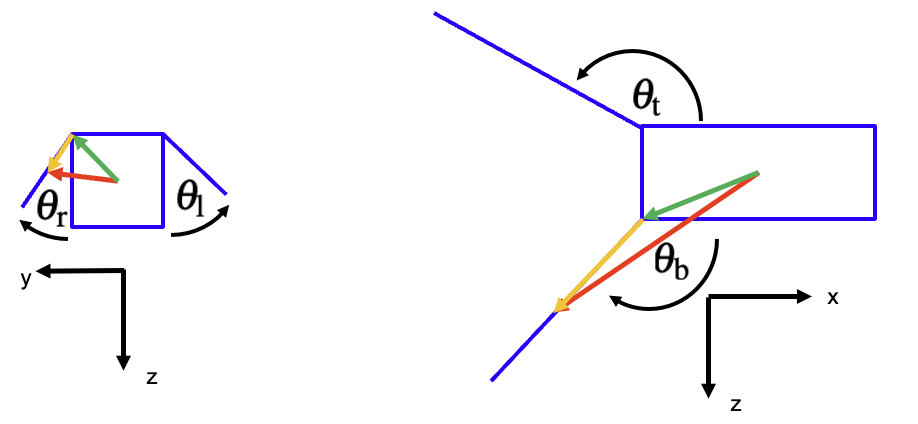

#### Below we show two sets of deployment angles. The first case corresponds to the "packaged" configuration. That is the configuration the spacecraft is in right after it's deployed from the ISS

In [6]:
# Packaged configuration
theta_t = 0 # Angle from folded state for top panel (0 to pi)
theta_b = 0 # Angle from folded state for bottom panel (0 to pi)
theta_l = 0 # Angle from folded state for left panel (0 to pi/2)
theta_r = 0 # Angle from folded state for right panel (0 to pi/2)

#### The second configuration is the fully deployed one. All the panels are deployed to the full extent. This is the configuration that corresponds to the maximum available solar power. 

In [7]:
# Fully deployed configuration

# left and right panels
theta_l = 90 * deg2rad # Angle from folded state for left panel (0 to pi/2)
theta_r = 90 * deg2rad # Angle from folded state for right panel (0 to pi/2)

# top and bottom panels
theta_t = 180 * deg2rad # Angle from folded state for top panel (0 to pi)
theta_b = 180 * deg2rad # Angle from folded state for bottom panel (0 to pi)

## 2. Determine centroid location

#### Next thing we do we specify the offsets of the COM for each solar panel with respect to the COM of the chassis.

In [8]:
# top panel
dx_t = - L / 2 + L / 2 * np.cos(theta_t)
dy_t = 0.0
dz_t = - W / 2 - L / 2 * np.sin(theta_t)

# bottom panel
dx_b = - L / 2 + L / 2 * np.cos(theta_b)
dy_b =   0.0
dz_b = + W / 2 + L / 2 * np.sin(theta_b)

# left panel
dx_l =   0.0
dy_l = - W / 2 - W / 2 * np.sin(theta_l)
dz_l = - W / 2 + W / 2 * np.cos(theta_l)

# right panel
dx_r =   0.0
dy_r = + W / 2 + W / 2 * np.sin(theta_r)
dz_r = - W / 2 + W / 2 * np.cos(theta_r)

Let's create arrays with those offsets

In [9]:
# Offset positions of the panel centroids
dr_t = np.array([dx_t, dy_t, dz_t])
dr_b = np.array([dx_b, dy_b, dz_b])
dr_l = np.array([dx_l, dy_l, dz_l])
dr_r = np.array([dx_r, dy_r, dz_r])

## 3. Calculate center of mass

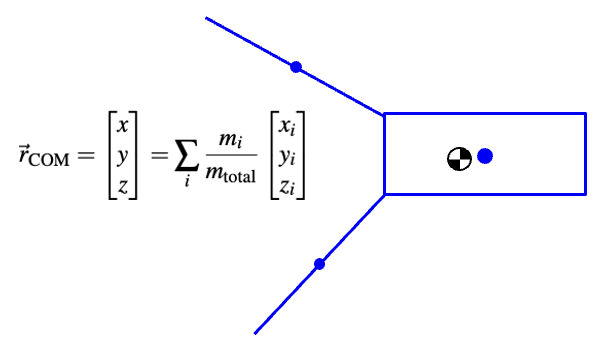

#### First, we compute the total mass

In [10]:
m_total = m_chassis + 4 * m_panel
print(m_total)

2.0


#### Next, we compute the COM of the spacecraft (for the fully deployed configuration). The center of mass of the spacecraft is a weighted average of the centers of mass of its components.

In [11]:
COM     = m_panel * (dr_t + dr_b + dr_l + dr_r) / m_total
print(COM)

[-0.022  0.    -0.004]


### Wait! But why is there nothing related to the chassis in the COM equation above?

## 4. Calculate each shape's moments of inertia

In [12]:
I_chassis = att.inertia_box(m_chassis, L, W, W) # axes: x-forward, y-right, z-down
I_panel   = att.inertia_plate(m_panel, L, W)

Let's look at the inertia tensors for the chassis. We multiply by 1000 just to make numbers closer to unity

In [13]:
print(I_chassis * 1000)

[[1.70666667 0.         0.        ]
 [0.         7.30666667 0.        ]
 [0.         0.         7.30666667]]


Let's look at the inertia tensor for a panel

In [14]:
print(I_panel   * 1000)

[[0.05333333 0.         0.        ]
 [0.         0.40333333 0.        ]
 [0.         0.         0.45666667]]


#### Now that we know the individual inertia tensors COMs, we can take each component and rotate & translate their moments of inertia to find the overall CubeSat's inertia tensor.

Here we have to be careful of our sign convention for the deployment angle of each panel, since a positive angle from the stowed configuration may be in a negative axis direction.  The left and right panels also start in a vertical orientation so their rotations are offset by $\pm \pi/2$

In [15]:
# First we take care of the chassis. The variable named "offset" is the offset between the COM of the component and the COM of the spacecraft.

offset_chassis = COM
I_chassis_COM  = att.inertia_translate(m_chassis, I_chassis, offset_chassis[0], offset_chassis[1], offset_chassis[2])

# For each panel, rotate first about its centroid and then translate through parallel axis theorem
I_panel_t_rot = att.inertia_rotate(I_panel, theta_t, 2)
offset_t      = COM - dr_t
I_panel_t_COM = att.inertia_translate(m_panel, I_panel_t_rot, offset_t[0], offset_t[1], offset_t[2])

I_panel_b_rot = att.inertia_rotate(I_panel, - theta_b, 2)
offset_b      = COM - dr_b
I_panel_b_COM = att.inertia_translate(m_panel, I_panel_b_rot, offset_b[0],offset_b[1], offset_b[2])

I_panel_l_rot = att.inertia_rotate(I_panel, - pi/2 + theta_l, 1)
offset_l      = COM - dr_l
I_panel_l_COM = att.inertia_translate(m_panel, I_panel_l_rot, offset_l[0], offset_l[1], offset_l[2])

I_panel_r_rot = att.inertia_rotate(I_panel, + pi/2 - theta_r, 1)
offset_r      = COM - dr_r
I_panel_r_COM = att.inertia_translate(m_panel, I_panel_r_rot, offset_r[0], offset_r[1], offset_r[2])

## 5. Add up individual inertias

In [16]:
# Sum all the inertias in the Center of Mass coordinate frame
I_cubesat = I_chassis_COM + I_panel_t_COM + I_panel_b_COM + I_panel_l_COM + I_panel_r_COM
print(I_cubesat)

[[0.003808   0.         0.000176  ]
 [0.         0.01824    0.        ]
 [0.000176   0.         0.01912533]]


As you can see, it is not a diagonal matrix. So, the coordinate axes are not principal axes. 

## 6. Find principal axes

In [17]:
principal_moments, principal_axes = att.principal_inertia(I_cubesat)

#### let's take a look at the principal moments of inertia

In [18]:
print(principal_moments)

[0.00380598 0.01912736 0.01824   ]


#### let's take a look at the principal axes

In [19]:
print(principal_axes)

[[-0.99993401 -0.01148798  0.        ]
 [ 0.          0.          1.        ]
 [ 0.01148798 -0.99993401  0.        ]]


## Given this principal moments and axes, does this look like we will be rotating stably around the spacecraft y-axis?

## Pset 3 1e

In [20]:
def Iyz_diff(theta_top, theta_side):
    # top panel
    dx_t = - L / 2 + L / 2 * np.cos(theta_top)
    dy_t = 0.0
    dz_t = - W / 2 - L / 2 * np.sin(theta_top)

    # bottom panel
    dx_b = - L / 2 + L / 2 * np.cos(theta_top)
    dy_b =   0.0
    dz_b = + W / 2 + L / 2 * np.sin(theta_top)

    # left panel
    dx_l =   0.0
    dy_l = - W / 2 - W / 2 * np.sin(theta_side)
    dz_l = - W / 2 + W / 2 * np.cos(theta_side)

    # right panel
    dx_r =   0.0
    dy_r = + W / 2 + W / 2 * np.sin(theta_side)
    dz_r = - W / 2 + W / 2 * np.cos(theta_side)

    # Offset positions of the panel centroids
    dr_t = np.array([dx_t, dy_t, dz_t])
    dr_b = np.array([dx_b, dy_b, dz_b])
    dr_l = np.array([dx_l, dy_l, dz_l])
    dr_r = np.array([dx_r, dy_r, dz_r])

    # Compute total mass
    m_total = m_chassis + 4 * m_panel

    # Find COM
    COM     = m_panel * (dr_t + dr_b + dr_l + dr_r) / m_total

    # Calculate inertia tensors for each shape
    I_chassis = att.inertia_box(m_chassis, L, W, W) # axes: x-forward, y-right, z-down
    I_panel   = att.inertia_plate(m_panel, L, W)

    # Rotate and translate inertia tensor to match with chassis body frame
    # First we take care of the chassis. The variable named "offset" is the offset between the COM of the component and the COM of the spacecraft.
    offset_chassis = COM
    I_chassis_COM  = att.inertia_translate(m_chassis, I_chassis, offset_chassis[0], offset_chassis[1], offset_chassis[2])

    # For each panel, rotate first about its centroid and then translate through parallel axis theorem
    I_panel_t_rot = att.inertia_rotate(I_panel, theta_t, 2)
    offset_t      = COM - dr_t
    I_panel_t_COM = att.inertia_translate(m_panel, I_panel_t_rot, offset_t[0], offset_t[1], offset_t[2])

    I_panel_b_rot = att.inertia_rotate(I_panel, - theta_b, 2)
    offset_b      = COM - dr_b
    I_panel_b_COM = att.inertia_translate(m_panel, I_panel_b_rot, offset_b[0],offset_b[1], offset_b[2])

    I_panel_l_rot = att.inertia_rotate(I_panel, - pi/2 + theta_l, 1)
    offset_l      = COM - dr_l
    I_panel_l_COM = att.inertia_translate(m_panel, I_panel_l_rot, offset_l[0], offset_l[1], offset_l[2])

    I_panel_r_rot = att.inertia_rotate(I_panel, + pi/2 - theta_r, 1)
    offset_r      = COM - dr_r
    I_panel_r_COM = att.inertia_translate(m_panel, I_panel_r_rot, offset_r[0], offset_r[1], offset_r[2])

    # Sum all the inertias in the Center of Mass coordinate frame
    I_cubesat = I_chassis_COM + I_panel_t_COM + I_panel_b_COM + I_panel_l_COM + I_panel_r_COM

    # Diagonalize and find principal moments
    principal_moments, principal_axes = att.principal_inertia(I_cubesat)

    # Find Iy - Iz
    # Figure out corresponding principle moments of inertia to the coordinate axis using dot products
    # abs value with the principal axes.
    y_axis = [0.0, 1.0, 0.0]
    z_axis = [0.0, 0.0, 1.0]

    # Take the transpose to store all 3 dot products as a vector
    proj_y = np.abs(principal_axes.T @ y_axis)
    proj_z = np.abs(principal_axes.T @ z_axis)

    # Find the index of the largest value of projection
    iy_i = np.argmax(proj_y)
    iz_i = np.argmax(proj_z)

    # Use index to match corresponding moment
    Iy = principal_moments[iy_i]
    Iz = principal_moments[iz_i]

    return Iy - Iz


#create a grid of values for the deployments angles
theta_top = np.linspace(0.1, 180, 100) * deg2rad
theta_side = np.linspace(0.1, 90, 100) * deg2rad
theta_top, theta_side = np.meshgrid(theta_top, theta_side)

# initialize a grid of values
dI = np.zeros(theta_top.shape)

#call function
for i in range(dI.shape[0]):
    for j in range(dI.shape[1]):
        dI[i,j] = Iyz_diff(theta_top[i, j], theta_side[i, j]) 


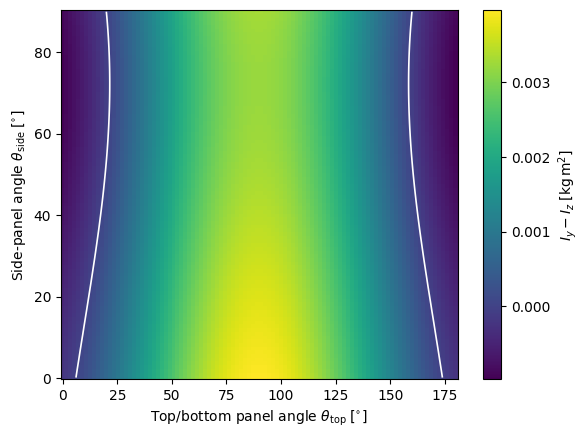

In [29]:
# Convert array from radians to degrees
deg_top  = np.rad2deg(theta_top)     
deg_side = np.rad2deg(theta_side)  

fig = plt.figure()
plt.pcolor(deg_top, deg_side, dI)

plt.xlabel(r"Top/bottom panel angle $\theta_{\rm top}\;[^{\circ}]$")
plt.ylabel(r"Side-panel angle $\theta_{\rm side}\;[^{\circ}]$")
cbar = plt.colorbar()

# show when Iy = Iz
plt.contour(
    deg_top,
    deg_side,
    dI,
    levels=[0.0],           # only the 0-level
    colors="white",
    linewidths=1.2,
)

cbar.set_label(r"$I_y-I_z\;[\mathrm{kg\,m^2}]$")


### 2b. Total Available Power Calculation (for full deployment)

In [ ]:
# Declare constants
eta = 0.3  # efficiency
solarFlux = 1370 # W/m^2
w_panel = 0.08 # m
l_panel = 0.22 # m

# Declare panel angles for fully deployed configuration
theta_side = np.pi / 2
theta_top = np.pi


# Find top-projected area of side panels and top panel
proj_A_side = w_panel * l_panel * np.sin(theta_side)
proj_A_top = w_panel * l_panel * -np.cos(theta_top)

# Compute total available power
proj_A = proj_A_side * 2 + proj_A_top + w_panel * l_panel # TOTAL area are the two side panels, plus top deployed panel, and the body panel
totalPower = proj_A * solarFlux * eta

print(f" {totalPower} W")

 28.9344 W


## 2c. Available Power vs. Deployment angles

In [ ]:
def availablePower(theta_top, theta_side):
    # Declare constants
    eta = 0.3  # efficiency
    solarFlux = 1370 # W/m^2
    w_panel = 0.08 # m
    l_panel = 0.22 # m

    # Find effective area of side panels
    proj_A_side = w_panel * l_panel * np.sin(theta_side)

    # Find effective area of top panel
    proj_A_top = w_panel * l_panel * -np.cos(theta_top) # negative area for 0° < θ < 90°
    proj_A_body = w_panel * l_panel

    # Compute total available power
    proj_A = proj_A_side * 2 + proj_A_body + proj_A_top # negative area accounts for overlap
    totalPower = proj_A * solarFlux * eta

    return totalPower


#create a grid of values for the deployments angles
theta_top = np.linspace(0.1, 180, 100) * deg2rad
theta_side = np.linspace(0.1, 90, 100) * deg2rad
theta_top, theta_side = np.meshgrid(theta_top, theta_side)

# initialize a grid of values
dPower = np.zeros(theta_top.shape)

#call function
for i in range(dPower.shape[0]):
    for j in range(dPower.shape[1]):
        dPower[i,j] = availablePower(theta_top[i, j], theta_side[i, j]) 

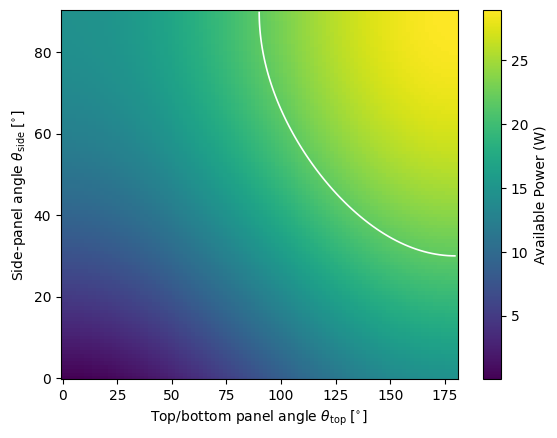

In [ ]:
# Convert array from radians to degrees
deg_top  = np.rad2deg(theta_top)     
deg_side = np.rad2deg(theta_side)  

fig = plt.figure()
plt.pcolor(deg_top, deg_side, dPower)

plt.xlabel(r"Top/bottom panel angle $\theta_{\rm top}\;[^{\circ}]$")
plt.ylabel(r"Side-panel angle $\theta_{\rm side}\;[^{\circ}]$")
cbar = plt.colorbar()
cbar.set_label(r"Available Power (W)")

plt.contour(
    deg_top,
    deg_side,
    dPower,
    levels=[21.70],
    colors="white",
    linewidths=1.2,
)


## 3